In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.datasets import load_iris

%matplotlib inline

In [3]:
df = pd.read_csv('features_reduced.csv', index_col=0)

In [4]:
df

,race,age,payer_code,admission_type_id,time_in_hospital,num_lab_procedures,diag_1,num_medications,Glucose_Measured,A1Cmeasurement,insulin,change,diabetesMed,readmitted
0,Caucasian,1,Unknown,6,1,41,250.83,1,No,No,No,No,No,Otherwise
1,Caucasian,2,Unknown,1,3,59,276,18,No,No,Up,Ch,Yes,Otherwise
2,AfricanAmerican,3,Unknown,1,2,11,648,13,No,No,No,No,Yes,Otherwise
3,Caucasian,4,Unknown,1,2,44,8,16,No,No,Up,Ch,Yes,Otherwise
4,Caucasian,5,Unknown,1,1,51,197,8,No,No,Steady,Ch,Yes,Otherwise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,8,Unknown,1,9,50,574,33,No,Yes,Steady,Ch,Yes,Otherwise
101755,Other,5,MD,1,14,73,592,26,No,Yes,Up,Ch,Yes,Otherwise
101756,Other,7,MD,1,2,46,996,17,No,No,Steady,No,Yes,Otherwise
101758,Caucasian,9,MC,1,5,76,292,22,No,No,Up,Ch,Yes,Otherwise


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69973 entries, 0 to 101765
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   race                69973 non-null  object
 1   age                 69973 non-null  int64 
 2   payer_code          69973 non-null  object
 3   admission_type_id   69973 non-null  int64 
 4   time_in_hospital    69973 non-null  int64 
 5   num_lab_procedures  69973 non-null  int64 
 6   diag_1              69973 non-null  object
 7   num_medications     69973 non-null  int64 
 8   Glucose_Measured    69973 non-null  object
 9   A1Cmeasurement      69973 non-null  object
 10  insulin             69973 non-null  object
 11  change              69973 non-null  object
 12  diabetesMed         69973 non-null  object
 13  readmitted          69973 non-null  object
dtypes: int64(5), object(9)
memory usage: 8.0+ MB


In [6]:
df['age']=df['age'].astype('object')

In [7]:
df['admission_type_id'] = df['admission_type_id'].astype('object')

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import confusion_matrix


#Feature Selection
X = df.drop(['readmitted'], axis=1)
y= df['readmitted']


#Label encode target variable 'y' into numerics
labenc = LabelEncoder()
y = labenc.fit_transform(y)


In [9]:
#Do the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.columns

Index(['race', 'age', 'payer_code', 'admission_type_id', 'time_in_hospital',
       'num_lab_procedures', 'diag_1', 'num_medications', 'Glucose_Measured',
       'A1Cmeasurement', 'insulin', 'change', 'diabetesMed'],
      dtype='object')

In [10]:
def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    
    #create unique column names by prefixing with feature name
    ohe_column_names = [f'{feature_name}_{category}' for category in ohe.categories_[0]]
    ohe_df = pd.DataFrame(feature_array, columns=ohe_column_names, index=X.index)

    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [11]:
def encode_and_concat_feature_train(X_train, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

In [12]:
categorical_feature_names = ['race', 'age', 'payer_code', 'admission_type_id',
       'diag_1', 'Glucose_Measured','A1Cmeasurement', 'insulin', 
       'change', 'diabetesMed']

encoders = {}

#Encode X_train and store encoders
for categorical_feature in categorical_feature_names:
    ohe,X_train = encode_and_concat_feature_train(X_train, categorical_feature)
    encoders[categorical_feature] = ohe



In [13]:
encoders

{'race': OneHotEncoder(handle_unknown='ignore'),
 'age': OneHotEncoder(handle_unknown='ignore'),
 'payer_code': OneHotEncoder(handle_unknown='ignore'),
 'admission_type_id': OneHotEncoder(handle_unknown='ignore'),
 'diag_1': OneHotEncoder(handle_unknown='ignore'),
 'Glucose_Measured': OneHotEncoder(handle_unknown='ignore'),
 'A1Cmeasurement': OneHotEncoder(handle_unknown='ignore'),
 'insulin': OneHotEncoder(handle_unknown='ignore'),
 'change': OneHotEncoder(handle_unknown='ignore'),
 'diabetesMed': OneHotEncoder(handle_unknown='ignore')}

In [14]:
def encode_and_concat_feature_test(X_test, feature_name, ohe):
    """
    Helper function for transforming test data. It takes in the full X_test dataframe,
    the feature name, and the already fitted encoder from X_train. Returns the transformed
    X_test with that feature encoded into multiple columns of 1s and 0s.
    """
    #Create new one-hot encoded df for the feature using the fitted encoder from X_train
    single_feature_df = X_test[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()

    #Ensure column names have same prefix structure as in X train
    ohe_column_names = [f'{feature_name}_{category}' for category in ohe.categories_[0]]
    ohe_df = pd.DataFrame(feature_array, columns = ohe_column_names, index=X_test.index)

    #Drop the old feature from X_test and concat the new one-hot encoded df
    X_test = X_test.drop(feature_name, axis=1)
    X_test = pd.concat([X_test, ohe_df], axis=1)
    
    return X_test

# Encode X_test using the fitted encoders
for categorical_feature in categorical_feature_names:
    X_test = encode_and_concat_feature_test(X_test, categorical_feature, encoders[categorical_feature])


In [15]:
X_train

,time_in_hospital,num_lab_procedures,num_medications,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,age_1,...,A1Cmeasurement_No,A1Cmeasurement_Yes,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
29262,1,36,24,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
54052,8,49,10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
93790,3,4,20,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
66811,2,53,12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
6103,5,44,49,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49643,1,3,7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
7670,9,48,33,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
77026,6,29,14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
921,7,69,23,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [16]:
X_test

,time_in_hospital,num_lab_procedures,num_medications,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,age_1,...,A1Cmeasurement_No,A1Cmeasurement_Yes,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
80578,6,60,21,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
60241,2,32,13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
68768,2,20,12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
47021,4,35,21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
80121,4,67,12,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6829,7,42,20,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
46177,6,18,16,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
16916,2,40,10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
64743,3,9,18,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [17]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
y_test


array([0, 0, 0, ..., 0, 0, 0])

In [19]:
X_train.shape, X_test.shape

((52479, 725), (17494, 725))

# Building the Classifier

This time we will have reduced features.

In [31]:
#Initialize the decision tree
tree_classifer = DecisionTreeClassifier(criterion='gini',splitter ='best',random_state=1000, max_depth=15,  # Increased from 10
    class_weight={0: 1, 1: 10},  # Give more weight to class 0
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt')

#fit it to the training data
tree_classifer.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, max_depth=15,
                       max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, random_state=1000)

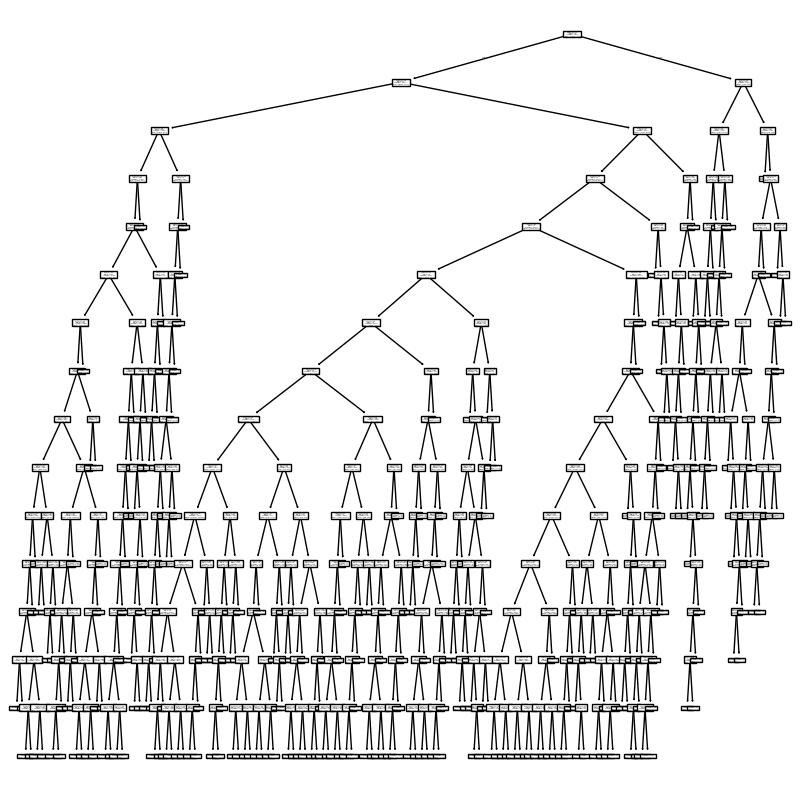

In [32]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree_classifer, ax=ax);

Looks like a simpler tree than our original one

## Evaluating the classifier

In [33]:
y_pred = tree_classifer.predict(X_test)

cfmat = confusion_matrix(y_test,y_pred, labels=tree_classifer.classes_ )

In [34]:
cfmat


array([[9071, 6812],
       [ 762,  849]])

In [35]:
labenc.inverse_transform(tree_classifer.classes_)


array(['Otherwise', 'within30'], dtype=object)

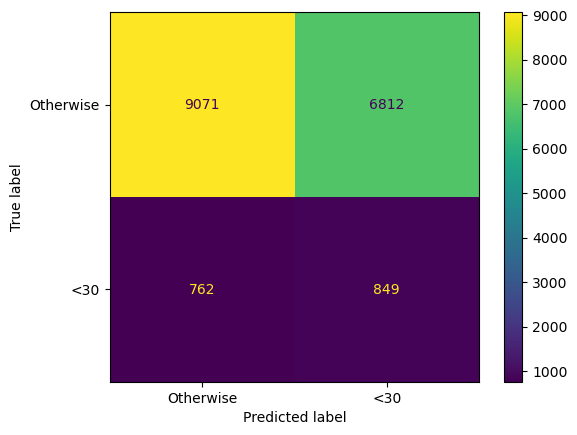

In [37]:
ConfusionMatrixDisplay.from_estimator(tree_classifer, X_test, y_test, display_labels=['Otherwise', '<30']);


In [38]:
tn, fp, fn, tp = cfmat.flatten()

In [39]:
tn, fp, fn, tp

(9071, 6812, 762, 849)

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [41]:
precision = precision_score(y_test, y_pred)
precision

0.11082104163947265

In [42]:
recall = recall_score(y_test, y_pred)
recall

0.527001862197393

In [43]:
f1 = f1_score(y_test, y_pred)
f1

0.18313201035375323

In [44]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.57      0.71     15883
           1       0.11      0.53      0.18      1611

    accuracy                           0.57     17494
   macro avg       0.52      0.55      0.44     17494
weighted avg       0.85      0.57      0.66     17494



Applying the SMOTE technique to the training data

In [45]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [46]:
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))


Original class distribution: Counter({0: 47813, 1: 4666})
Resampled class distribution: Counter({0: 47813, 1: 47813})


In [51]:
from sklearn.feature_selection import RFECV

# Initialize the decision tree classifier
tree_classifier = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    random_state=1000,
    max_depth=10,
    class_weight='balanced',
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt'
)



In [54]:
# Use ecursive Feature Elimination with Cross-Validation
rfe = RFECV(estimator=tree_classifier, step=5, cv=3, scoring='f1',n_jobs=-1 # Use all available cores
)
rfe.fit(X_train_resampled, y_train_resampled)


RFECV(cv=3,
      estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                                       max_features='sqrt', min_samples_leaf=2,
                                       min_samples_split=5, random_state=1000),
      n_jobs=-1, scoring='f1', step=5)

In [ ]:
# Get selected features from the RFE
selected_features = X_train_resampled.columns[rfe.support_]
print("Optimal number of features:", rfe.n_features_)
print("Selected features:", selected_features)

In [ ]:
X_train_selected = X_train_resampled[selected_features]
X_test_selected = X_test[selected_features]

Fit the model on the reselected and resampled data

In [48]:
tree_classifier.fit(X_train_selected, y_train_resampled)


DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, random_state=1000)

In [49]:
# Make predictions on the test set
y_pred = tree_classifier.predict(X_test_selected)

              precision    recall  f1-score   support

           0       0.91      0.74      0.81     15883
           1       0.10      0.29      0.15      1611

    accuracy                           0.70     17494
   macro avg       0.51      0.51      0.48     17494
weighted avg       0.84      0.70      0.75     17494



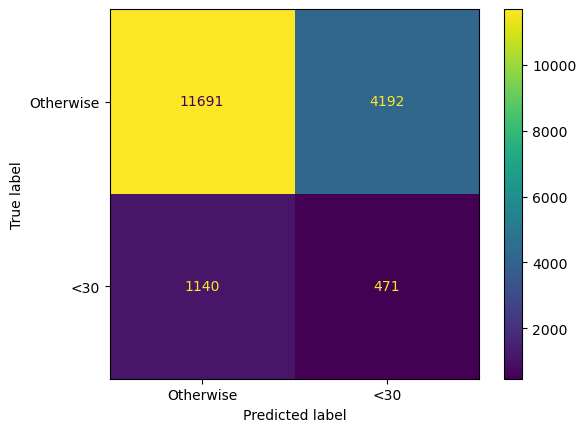

In [50]:
# Evaluate the model
print(classification_report(y_test, y_pred))

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(tree_classifier, X_test, y_test, display_labels=['Otherwise', '<30'])
plt.show()
